# EDA: Data Insights
-------



### Notebook Summary

In this notebook, I perform an Exploratory Data Analysis (EDA) on a cleaned dataset of headphones scraped from Amazon. The objective is to identify patterns and insights that are relevant for building a recommendation system.

I begin with univariate analysis, examining each feature of the dataset individually.

From there, I will conduct multivariate analysis to uncover insights about how features are related and the strength of these relationships.


## Set Up
-----

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


## Utility Functions
----

## Data Loading
----

In [3]:
df = pd.read_csv('../../data/cleaned_headphones_data.csv', index_col = 0)

## Univariate Analysis
-----

In [4]:
eda_df = df.copy()

In [5]:
eda_df['Battery Life'] = eda_df['Battery Life'].replace('Not Specified', 0)

In [6]:
eda_df['Battery Life'] = eda_df['Battery Life'].astype(int)

### Get numerical columns

In [7]:
num_cols = eda_df.select_dtypes(exclude='object').columns

In [8]:
num_cols

Index(['Price', 'Rating', 'Is Prime', 'Wireless', 'Noise Cancelling',
       'Battery Life', 'Microphone', 'Over Ear', 'Gaming', 'Foldable'],
      dtype='object')

In [9]:
num_cols = ['Price', 'Rating', 'Battery Life'] # Ignoring bool columns for now

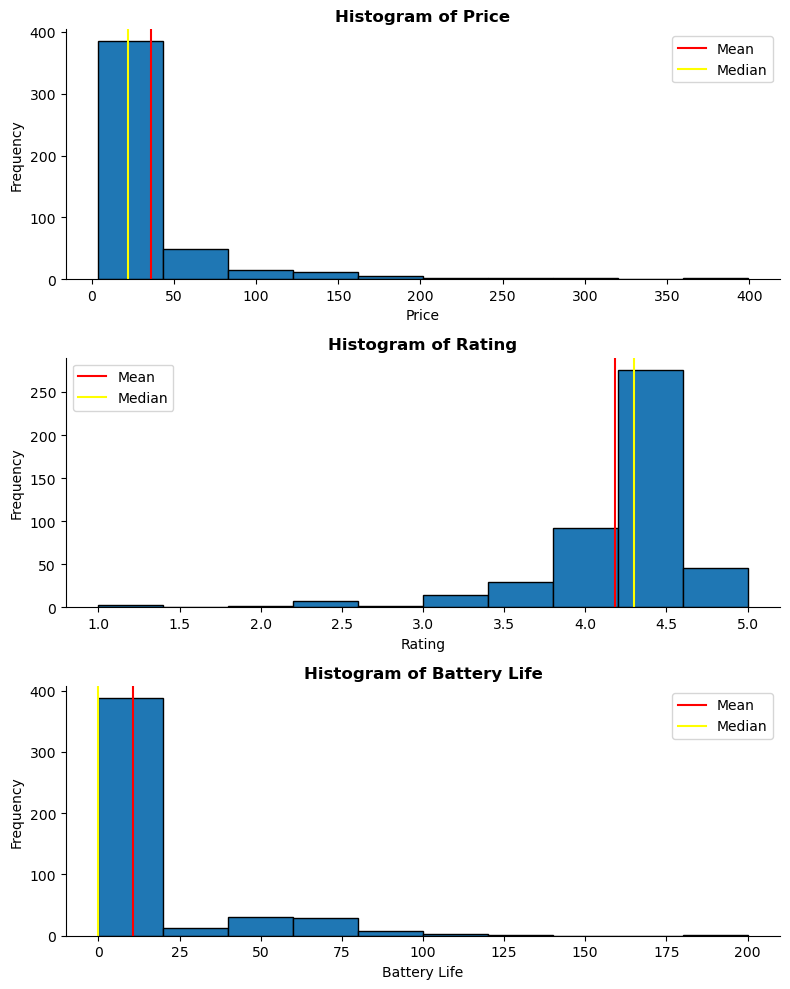

In [10]:
plt.figure(figsize=(8, 10))  # Set the figure size

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i+1)  # Create a subplot for each column
    plt.hist(eda_df[col], bins=10, edgecolor='black')  # Plot histogram
    plt.title(f'Histogram of {col}', fontweight = 'bold')
    plt.axvline(eda_df[col].mean(), color = 'red', label = 'Mean')
    plt.axvline(eda_df[col].median(), color = 'yellow', label = 'Median')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    ax = plt.gca()

    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

-----
**Plot Description**

***EDA: FIRST PASS (SCRAPING 30 PAGES)***


**PRICE:**
- Highly skewed to the right with the median less than the mean - the outliers (higher priced headphones) are pulling the mean to the right.
- Most products are priced less than £100 with a few pricier headphones pulling the tail to the right.
- This could lead to bias towards budget priced headphones, it may be worth performing the scraping again with more results to try even out the bias if possible.


**RATING:**
- Highly skewed to the left with most headphones having a rating above 4 out of 5 stars.
- This could be due to Amazon promoting higher-rated products more prominently on its pages. As a result, lower-rated products may not appear frequently in search results or in the first pages of results.
- The skewing and bias of ratings could hinder the recommendor system, it becomes harder to diffrentiate between good and poor quality.

**BATTERY LIFE:**

- One product has a 600-hour battery life, which seems unusually high for headphones. This might need further investigation for accuracy.
- Most headphones have a battery life less than 100 hours, which seems reasonable.
- Gaps in 70% of the data for battery life, this could limit the reliability of any insights based on battery life. May need to exlcude this feature from the recommeder system but will see if there any other better solutions.

***EDA: SECOND PASS (SCRAPING 30 PAGES)***

Similar insights as first pass:

**PRICE:**
- Data is skewed to the right, since I increased the results it is likley that the price distribution I see is representative of the headphone market on Amazon.
- Therefore I will need to transform this feature to make the distribution more normal.

**RATING:**
- Data is still skewed to the left after increasing the data, deciding not to transform the rating as this is shows the true satisfaction of users.

**BATTERY LIFE:**
- Removed the outlier of 600 hour battery life by fixing the regular expression in data-cleaning notebook.
- Since there are still a lot of data gaps in this field, I don't think it best to transform this feature. May have to think of a better way to include this feature in the recommender system.

In [11]:
# EDA: FIRST PASS (SCRAPING 30 PAGES)
# One product has a 600-hour battery life, which seems unusually high for headphones
pd.set_option('display.max_colwidth', None)
eda_df[eda_df['Battery Life'] > 500]['Description']
# Seems like I need to go back and fix the regexp for extracting battery life

# EDA: SECOND PASS (SCRAPING 50 PAGES)
# One product has a 200-hour battery life, checking to see if this is an anamoly
pd.set_option('display.max_colwidth', None)
eda_df[eda_df['Battery Life'] > 175]['Description']

157    wireless bluetooth headphones over ear, 200h playtime bluetooth headphones foldable wireless headset with microphone, soft earmuffs wired and wireless mode, hifi stereo headset for school/tablet/pc
Name: Description, dtype: object

#### Log Transformation of Price

In [12]:
eda_df['price_trans'] = np.log(eda_df['Price'])

<Axes: ylabel='Frequency'>

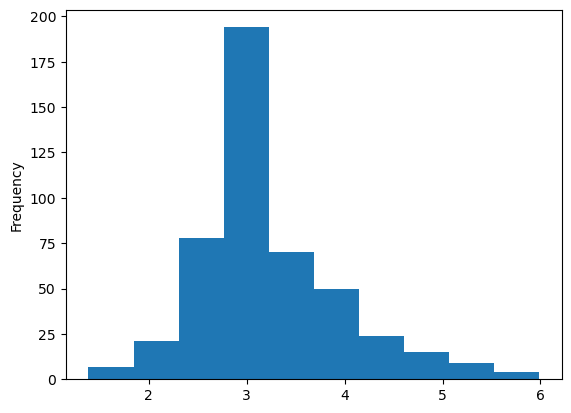

In [13]:
eda_df['price_trans'].plot(kind='hist')


### Boolean Columns

In [14]:
bool_cols = ['Is Prime', 'Wireless', 'Noise Cancelling', 'Microphone', 'Over Ear', 'Gaming', 'Foldable']

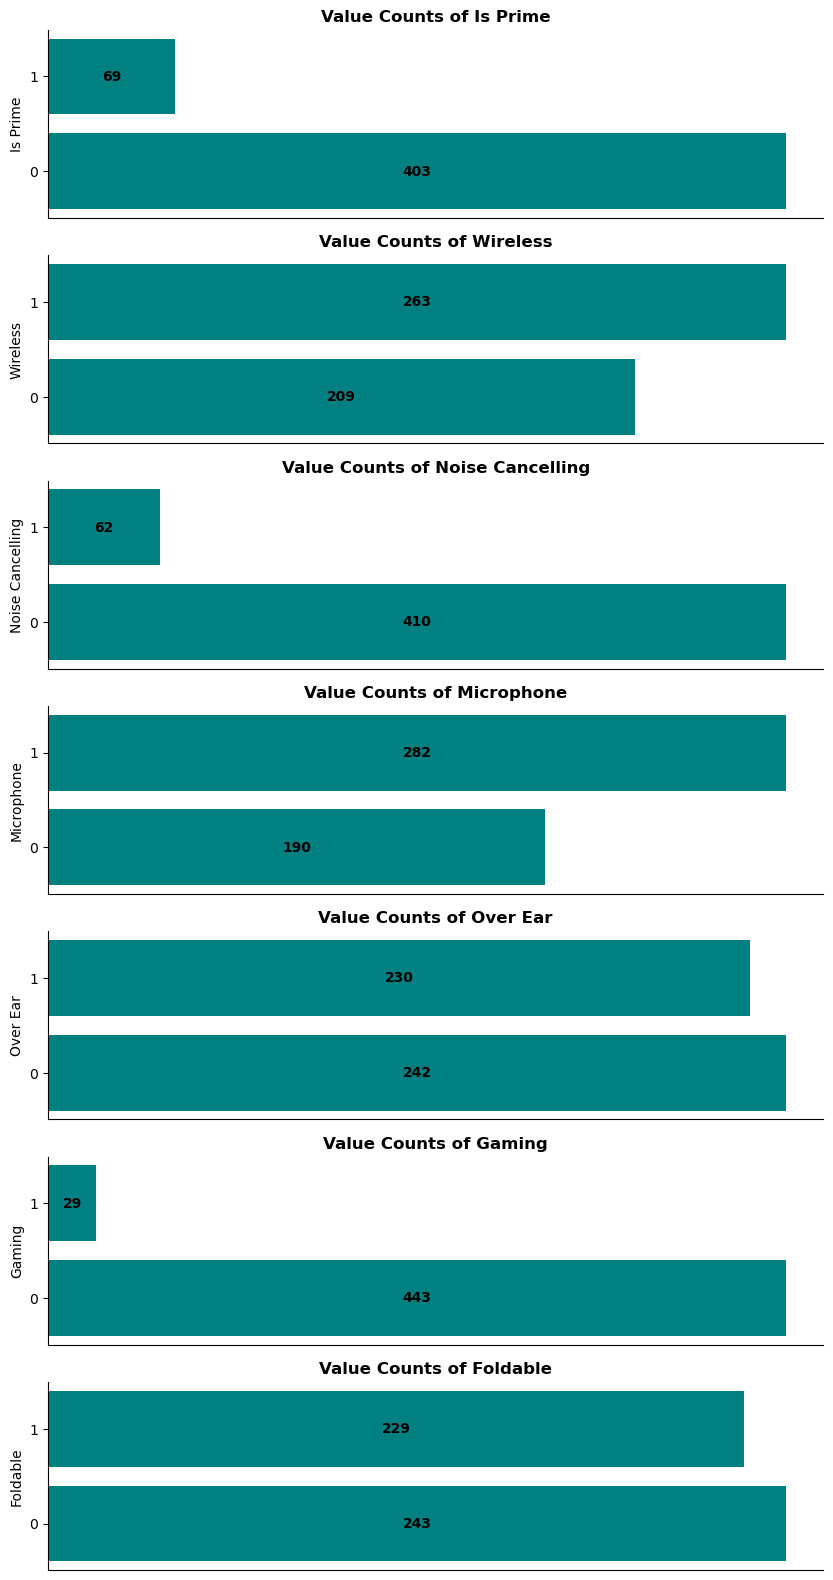

In [15]:
plt.figure(figsize=(10, 20)) 

for i, col in enumerate(bool_cols):
    plt.subplot(len(bool_cols), 1, i+1) 
    plt.barh(eda_df[col].value_counts().index, eda_df[col].value_counts().values)
    plt.bar_label(plt.barh(eda_df[col].value_counts().index, eda_df[col].value_counts().values, color = 'teal'), label_type='center', fontweight = 'bold')
    plt.title(f'Value Counts of {col}', fontweight = 'bold')
    plt.xticks([])
    plt.yticks([0,1])
    plt.ylabel (f'{col}')
    ax = plt.gca()

    ax.spines[['top', 'right']].set_visible(False) 

plt.show()

------
**Plot Description:**

***EDA: FIRST PASS (SCRAPING 30 PAGES)***

**Is Prime**
- Clear class imbalance with most headohones having prime eligibility
- Since most of the products are Prime, it may not add much to the recommeder system and may need to be weighted less in the model.


**Wireless** 
- Less of a class imbalance with a decent split between wireless and wired headphones.
- More suitable to be used in a recommeder system

**Noise Cancelling** 
- See a very strong class imbalance with most headphones not having this feature
- This may be more of a premium headphone feature, if I want to include it in the recommeder system I will have to somehow think of a way to minimise the impact of this imbalance on the recommender system.

**Microphone**  
- Minor class imbalance, not as drastic as other features
- To keep this feature as it will be useful feature for users who are looking for headphones to use for work or gaming.

**Over Ear** 
- Almost perfect class split

**Gaming**  
- Strong class imbalance with very few gaming specific headphones
- Gaming headphones can be considered to be a niche product and isn't likley to be relevant to all users. 

**Foldable**
- Balanced split between the classes.

***EDA: FIRST PASS (SCRAPING 30 PAGES)***

Still similar imbalances in all features like seen in the first EDA pass.

At this point, I am unlikely to take any steps to address the class imbalances. Since the data was collected through scraping, I want to preserve its representation of the market. Introducing additional data to balance the classes could introduce my own biases. If possible, I will attempt to address the imbalance issues when building the recommender.

### Category Columns

In [16]:
cat_cols = eda_df.select_dtypes(include = 'object').columns

In [17]:
cat_cols # only really want colour

Index(['Product ID', 'Description', 'Colour'], dtype='object')

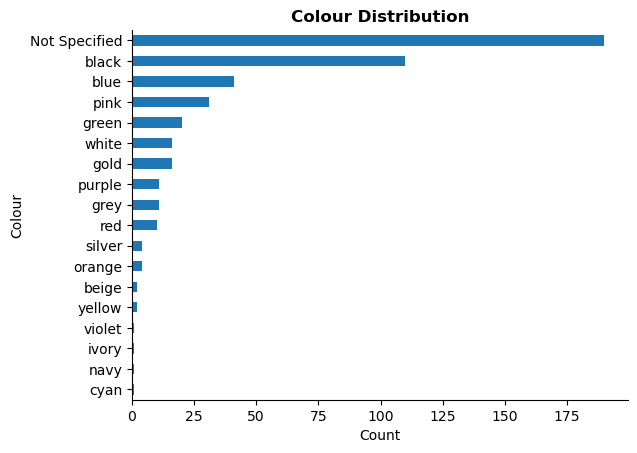

In [18]:
eda_df['Colour'].value_counts().sort_values(ascending=True).plot(kind = 'barh')
ax = plt.gca()
ax.spines[['top','right']].set_visible(False)
ax.set_title('Colour Distribution', fontweight = 'bold')
ax.set_xlabel('Count')
plt.show()

----
**Plot Description:**

***EDA: FIRST PASS (SCRAPING 30 PAGES)***

**Not Specified:** 

The largest proportion of headphones do not have a colour specified in the product description. This feature may not be one that is common to add to the product description?

**Popular Colors:**

- *Black*: The most popular colour choice, suggesting that black headphones are a preferred colour.
- *Blue* and *Pink*: These colours are also popular.

**Less Common Colors:**

- Colours such as *White*, *Green* and *Gold* show a lower presence, suggesting these colours are a less common choice.
- Colours like *Purple*, *Grey*, *Red* and others show an even lower presence.

***EDA: SECOND PASS (SCRAPING 50 PAGES)***

Similar findngs to first pass.

#### Encoding of Colour 

In [19]:
# To first put least popular colours in other category (reduce column explosion on encoding)
df['Colour'].value_counts()

Colour
Not Specified    190
black            110
blue              41
pink              31
green             20
white             16
gold              16
purple            11
grey              11
red               10
silver             4
orange             4
beige              2
yellow             2
ivory              1
navy               1
violet             1
cyan               1
Name: count, dtype: int64

In [20]:
# If value counts of colour is less than 10, category will be other
colours_to_grp = df['Colour'].value_counts() < 10

In [21]:
eda_df['Colour'] = eda_df['Colour'].replace(colours_to_grp[colours_to_grp].index, 'Other')

In [22]:
eda_df['Colour'].value_counts()

Colour
Not Specified    190
black            110
blue              41
pink              31
green             20
Other             16
gold              16
white             16
purple            11
grey              11
red               10
Name: count, dtype: int64

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(eda_df[['Colour']])
colour_df = pd.DataFrame(one_hot_encoded.toarray(),columns = encoder.get_feature_names_out(['Colour']))

In [71]:
# Step 4: Concatenate the original DataFrame and the one-hot encoded DataFrame
eda_df_final = pd.concat([eda_df, colour_df], axis=1)

# Step 5: (Optional) Drop the original 'Colour' column if no longer needed
eda_df_final = eda_df_final.drop(columns=['Colour', 'Price'])

In [72]:
eda_df_final.columns

Index(['Product ID', 'Description', 'Rating', 'Is Prime', 'Wireless',
       'Noise Cancelling', 'Battery Life', 'Microphone', 'Over Ear', 'Gaming',
       'Foldable', 'price_trans', 'Colour_Not Specified', 'Colour_Other',
       'Colour_black', 'Colour_blue', 'Colour_gold', 'Colour_green',
       'Colour_grey', 'Colour_pink', 'Colour_purple', 'Colour_red',
       'Colour_white'],
      dtype='object')

----
**Comment:**

Deciding to rerun the scraping increasing pages from 30 to 50 pages of results from the results of the univariate analysis. 

If I still see skewness in the data after this (highly likley) I will transform the data before moving to the multivariate analysis.


## Multivariate Anlaysis
-----

Using data from second scraping pass (50 pages)

### Pair Plot of Numeric Columns

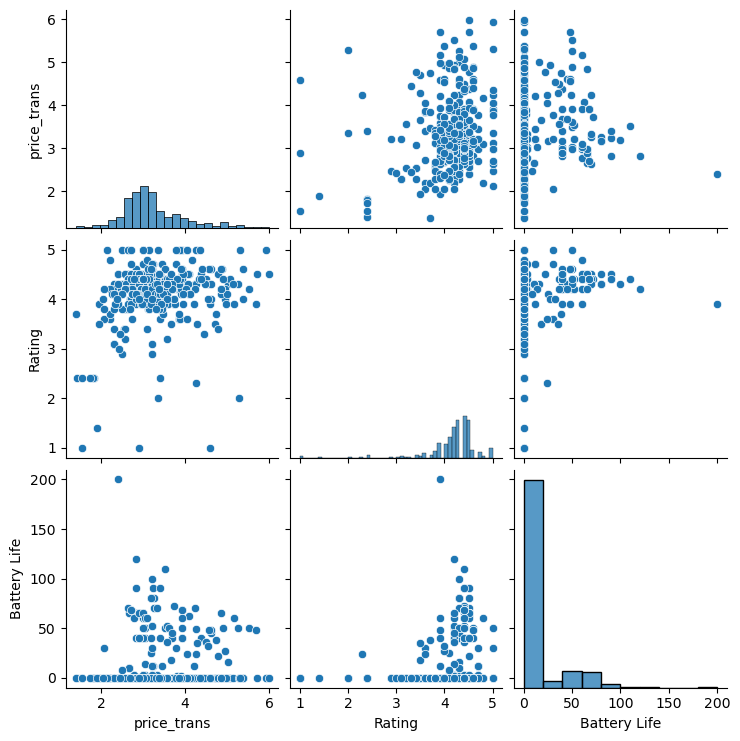

In [27]:
# Selecting most important numeric columns for pairplot
sns.pairplot(eda_df_final[['price_trans', 'Rating', 'Battery Life']])
plt.show()


-----
**Plot Description:**

Here, I am looking to see if any of the numerical columns are highly correlated with each other.

It seems as if there isn't a strong linear correlation between any features meaning the changes of one feature is not reflected in another. 

This may be due to the limiations of craeting a dataset from webscraping. Amazon likely uses algorithms that influence which products are displayed in search results. This could introduce biases into the dataset and this is what we may be seeing here. To use a correlation matrix to check findings.

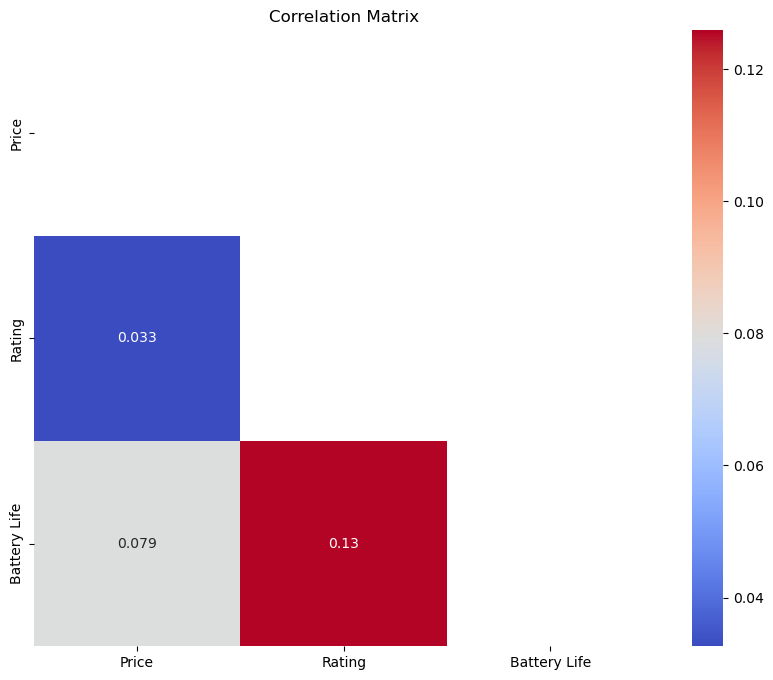

In [28]:
corr = eda_df_final[['Price', 'Rating', 'Battery Life']].corr()
mask =- np.triu(corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.show()

----
**Plot Description:**

The correlation matrix also shows there is very weak correlation between the numeric features.

### Boolean Columns with Price: Box Plots

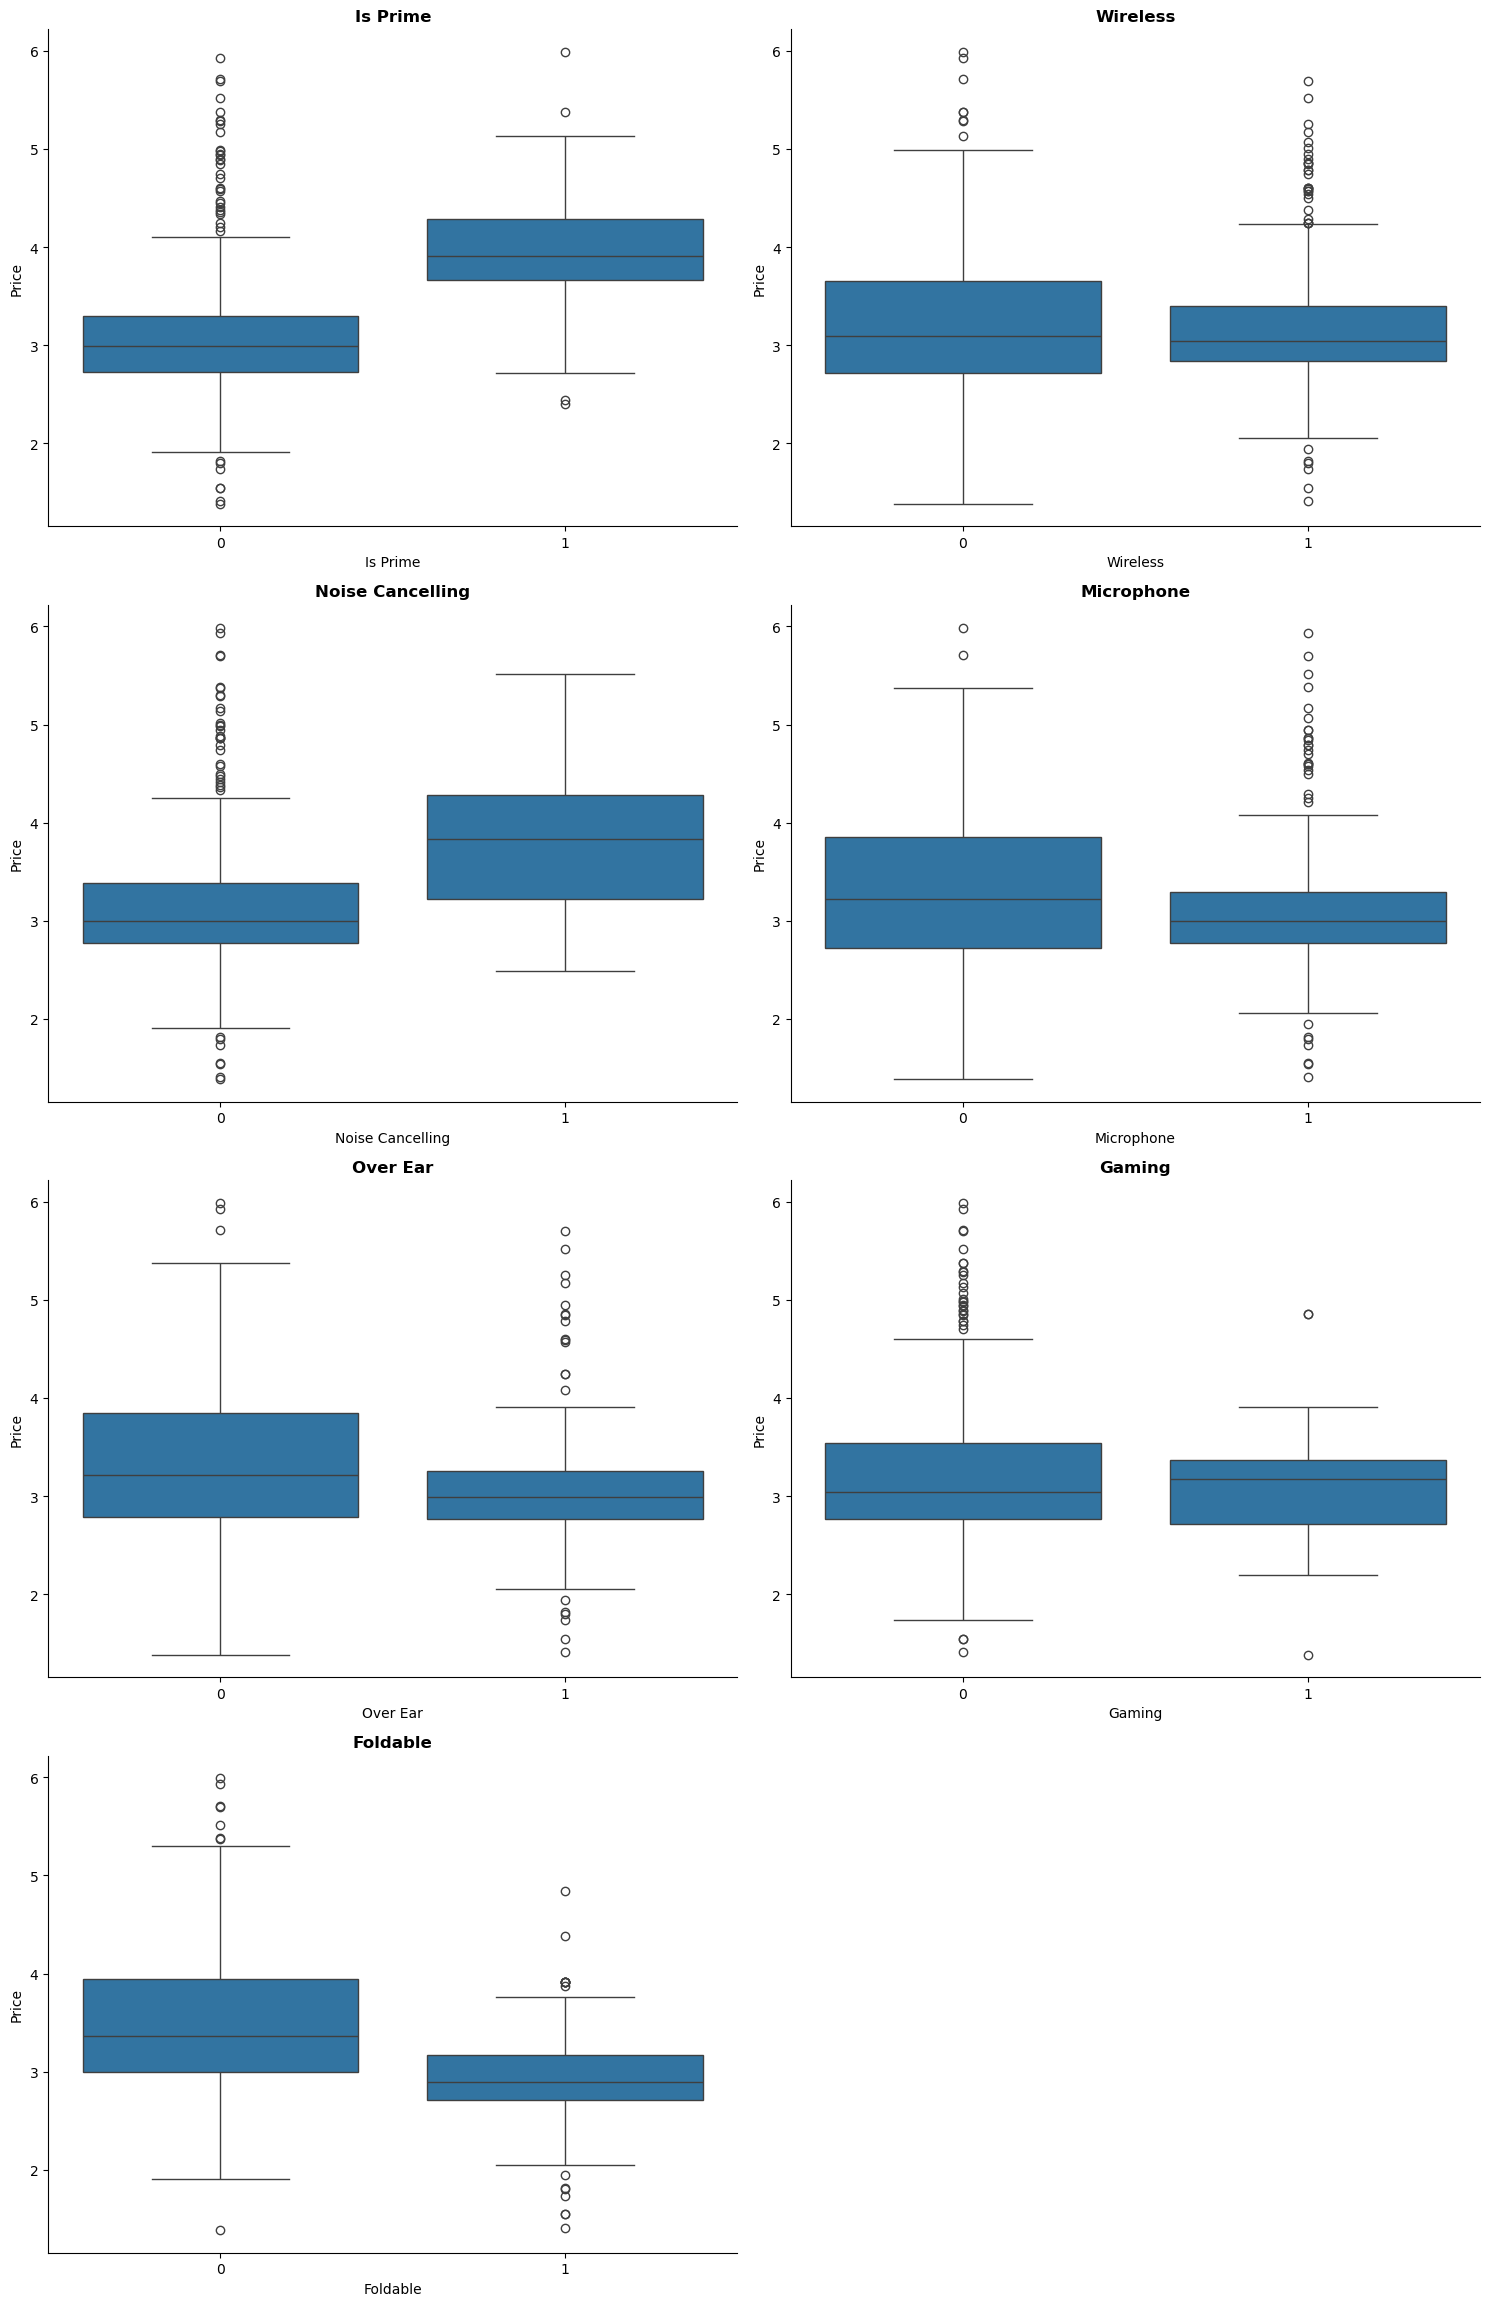

In [29]:
plt.figure(figsize=(15, 40)) 

for i, col in enumerate(bool_cols):
    plt.subplot(len(bool_cols), 2, i + 1)  
    sns.boxplot(x=col, y='price_trans', data=eda_df_final) 
    plt.title(f'{col}', fontweight='bold') 
    plt.xlabel(col)  
    plt.ylabel('Price')  
    ax = plt.gca()
    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout() 
plt.show()  

----
**Plot Description:**

Note since I have not yet dealt with the class imbalances, the insights could be skewed. 

**Is Prime**
- Prime products tend to be more expensive on average than non-prime products.
- There are more outliers in non-prime products, indicating more price variation.

**Wireless** 
- The average price of wired and wireless headphones appears to be similar.

**Noise Cancelling** 
- Noise-cancelling headphones are more expensive on average than non-noise-cancelling models, which is expected given that noise-cancellation is often considered a premium feature.
-There are more outliers in the non-noise-cancelling group, possibly due to other features that affect price.

**Microphone**  
- Headphones with microphones tend to be slightly cheaper than those without
- The presence of many outliers in headphones with microphones suggests other headphone features influence price more.

**Over Ear** 
- Over-ear headphones are slighlt lower priced on average than in-ear headphones.

**Gaming**  
- Gaming and non-gaming headphones share smiliar prices with non-gaming have more outliers. 

**Foldable**
- Non-foldable headphones are more expensive on average than foldable ones.

### Categorical Columns with Rating: Box Plots

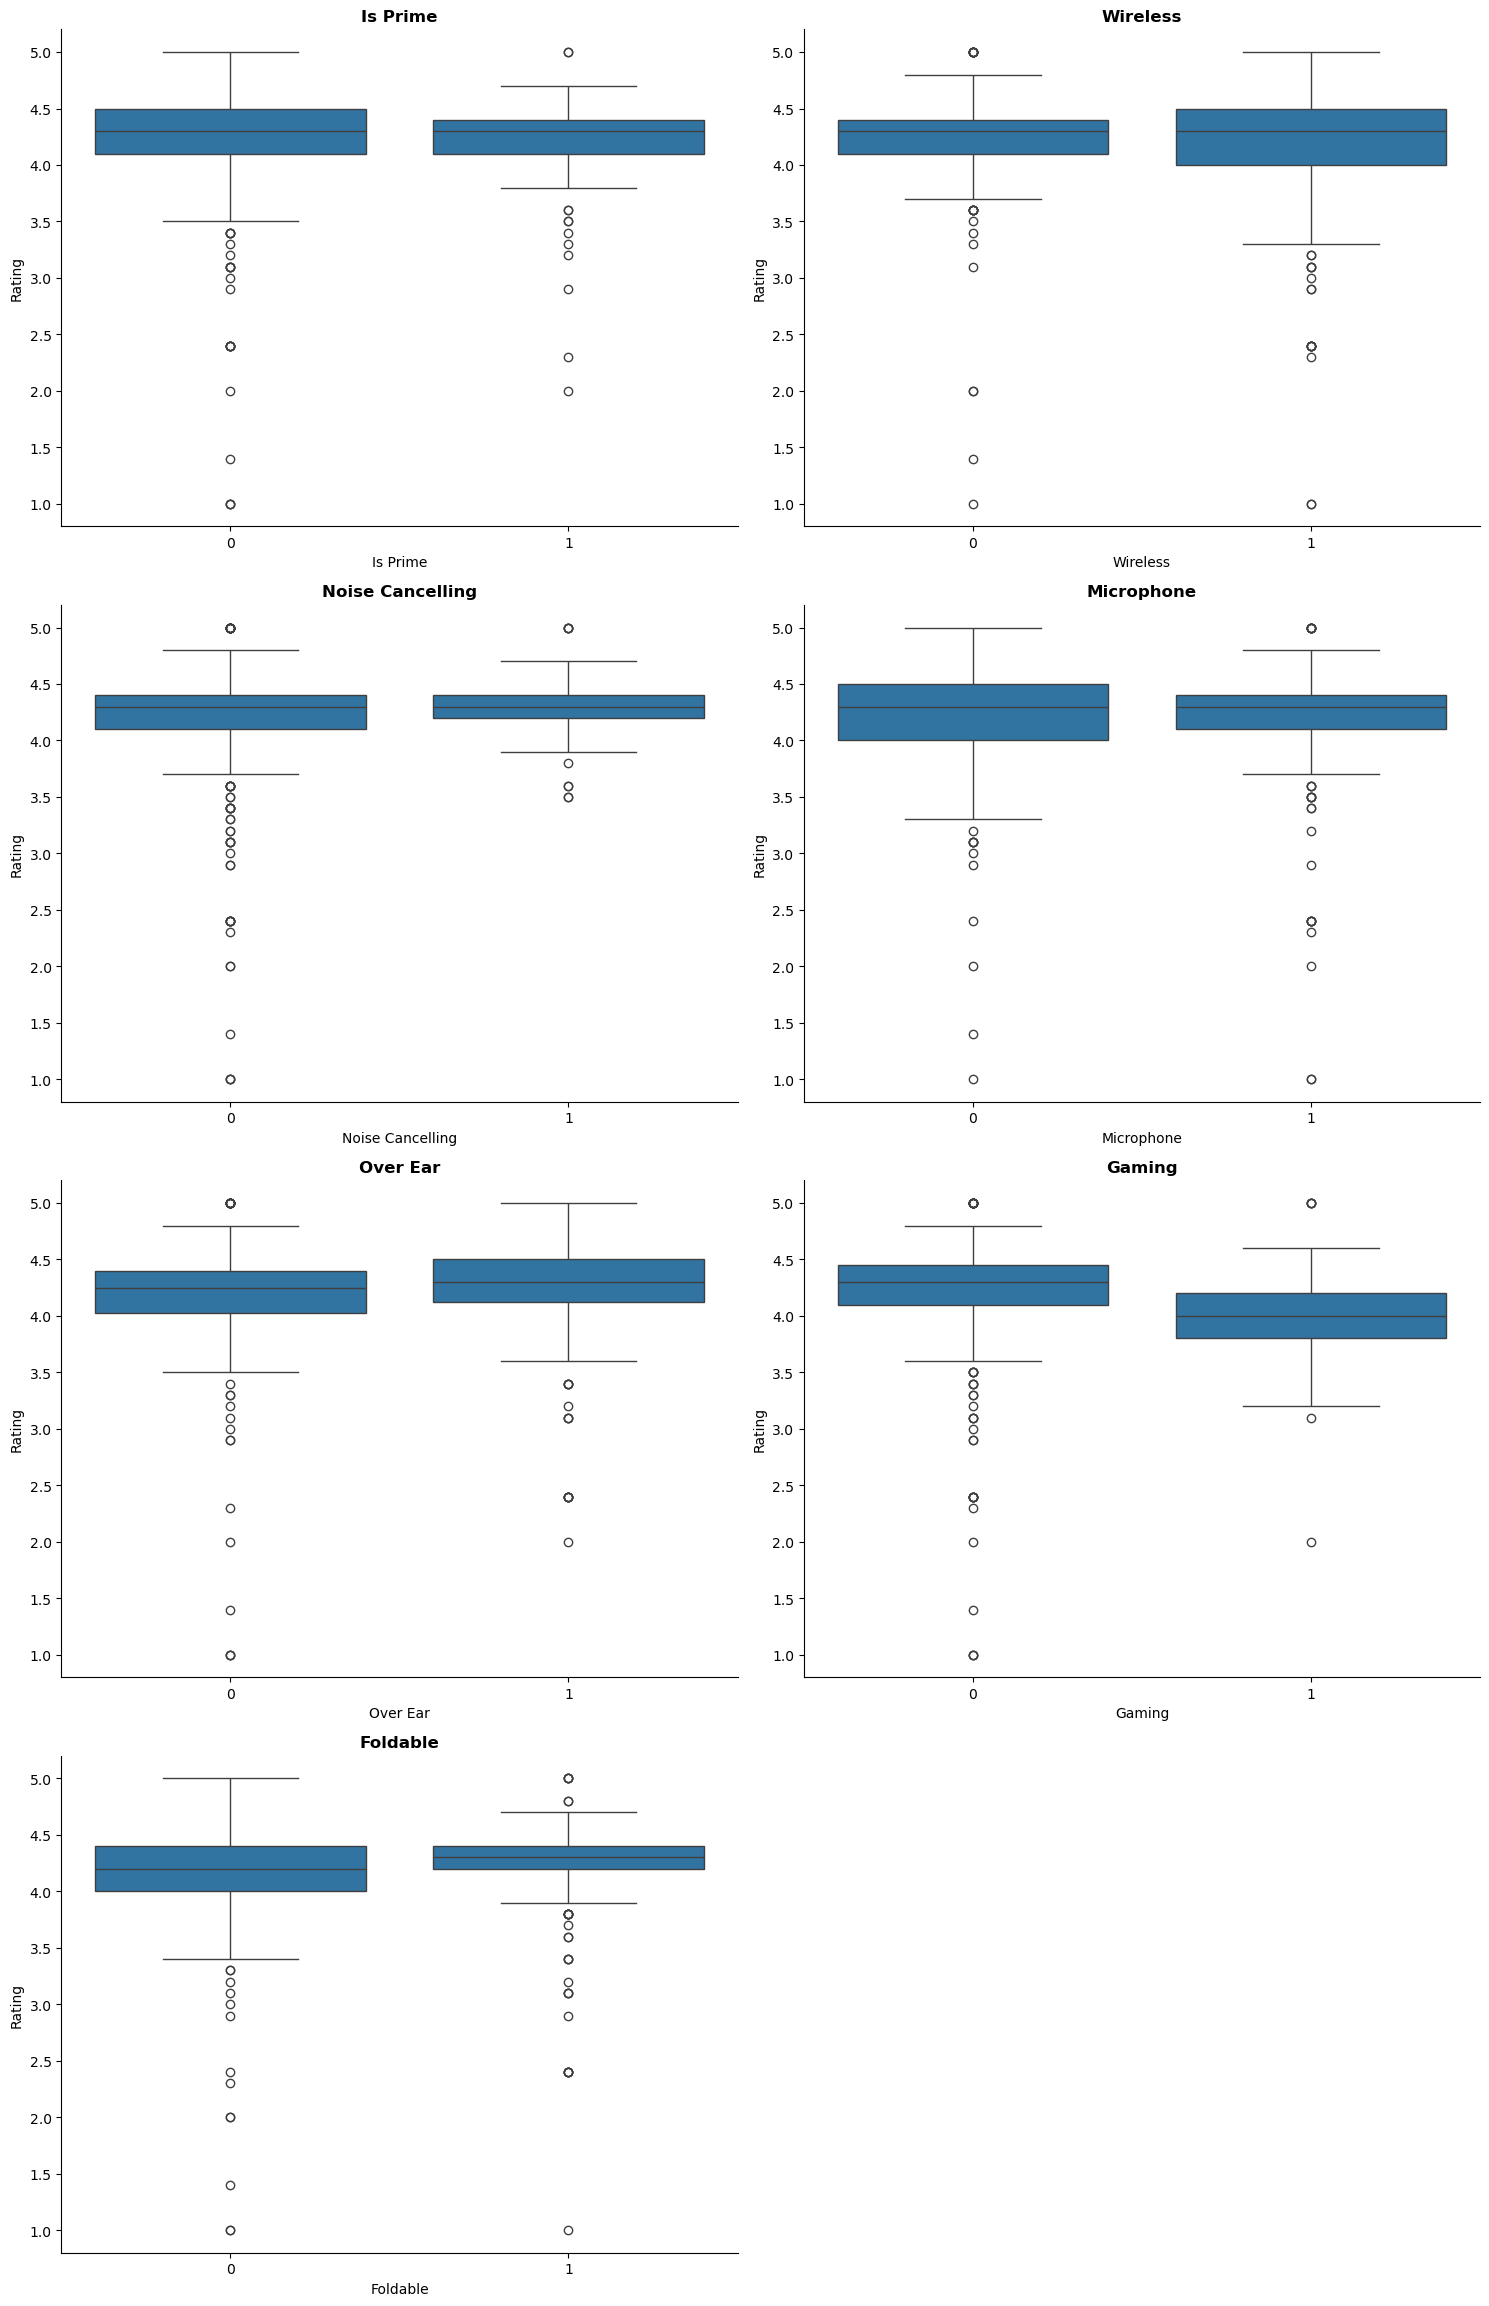

In [30]:
plt.figure(figsize=(15, 40)) 

# Loop through each boolean column
for i, col in enumerate(bool_cols):
    plt.subplot(len(bool_cols), 2, i + 1)
    sns.boxplot(x=col, y='Rating', data=eda_df) 
    plt.title(f'{col}', fontweight='bold')  
    plt.xlabel(col)  # Set x-label
    plt.ylabel('Rating')  # Set y-label

    ax = plt.gca()
    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout() 
plt.show()

----
**Plot Description:**

There isn't much difference in the average ratings between the classes for most features. This could be due to the high proportion of high ratings in the dataset, which makes it harder to observe differences across the different features.


### Colours Against Price

In [52]:
colour_cols = []    
for col in eda_df_final.columns:
    if col.startswith('Colour_'):
        col = col.replace('Colour_', '')
        colour_cols.append(col)

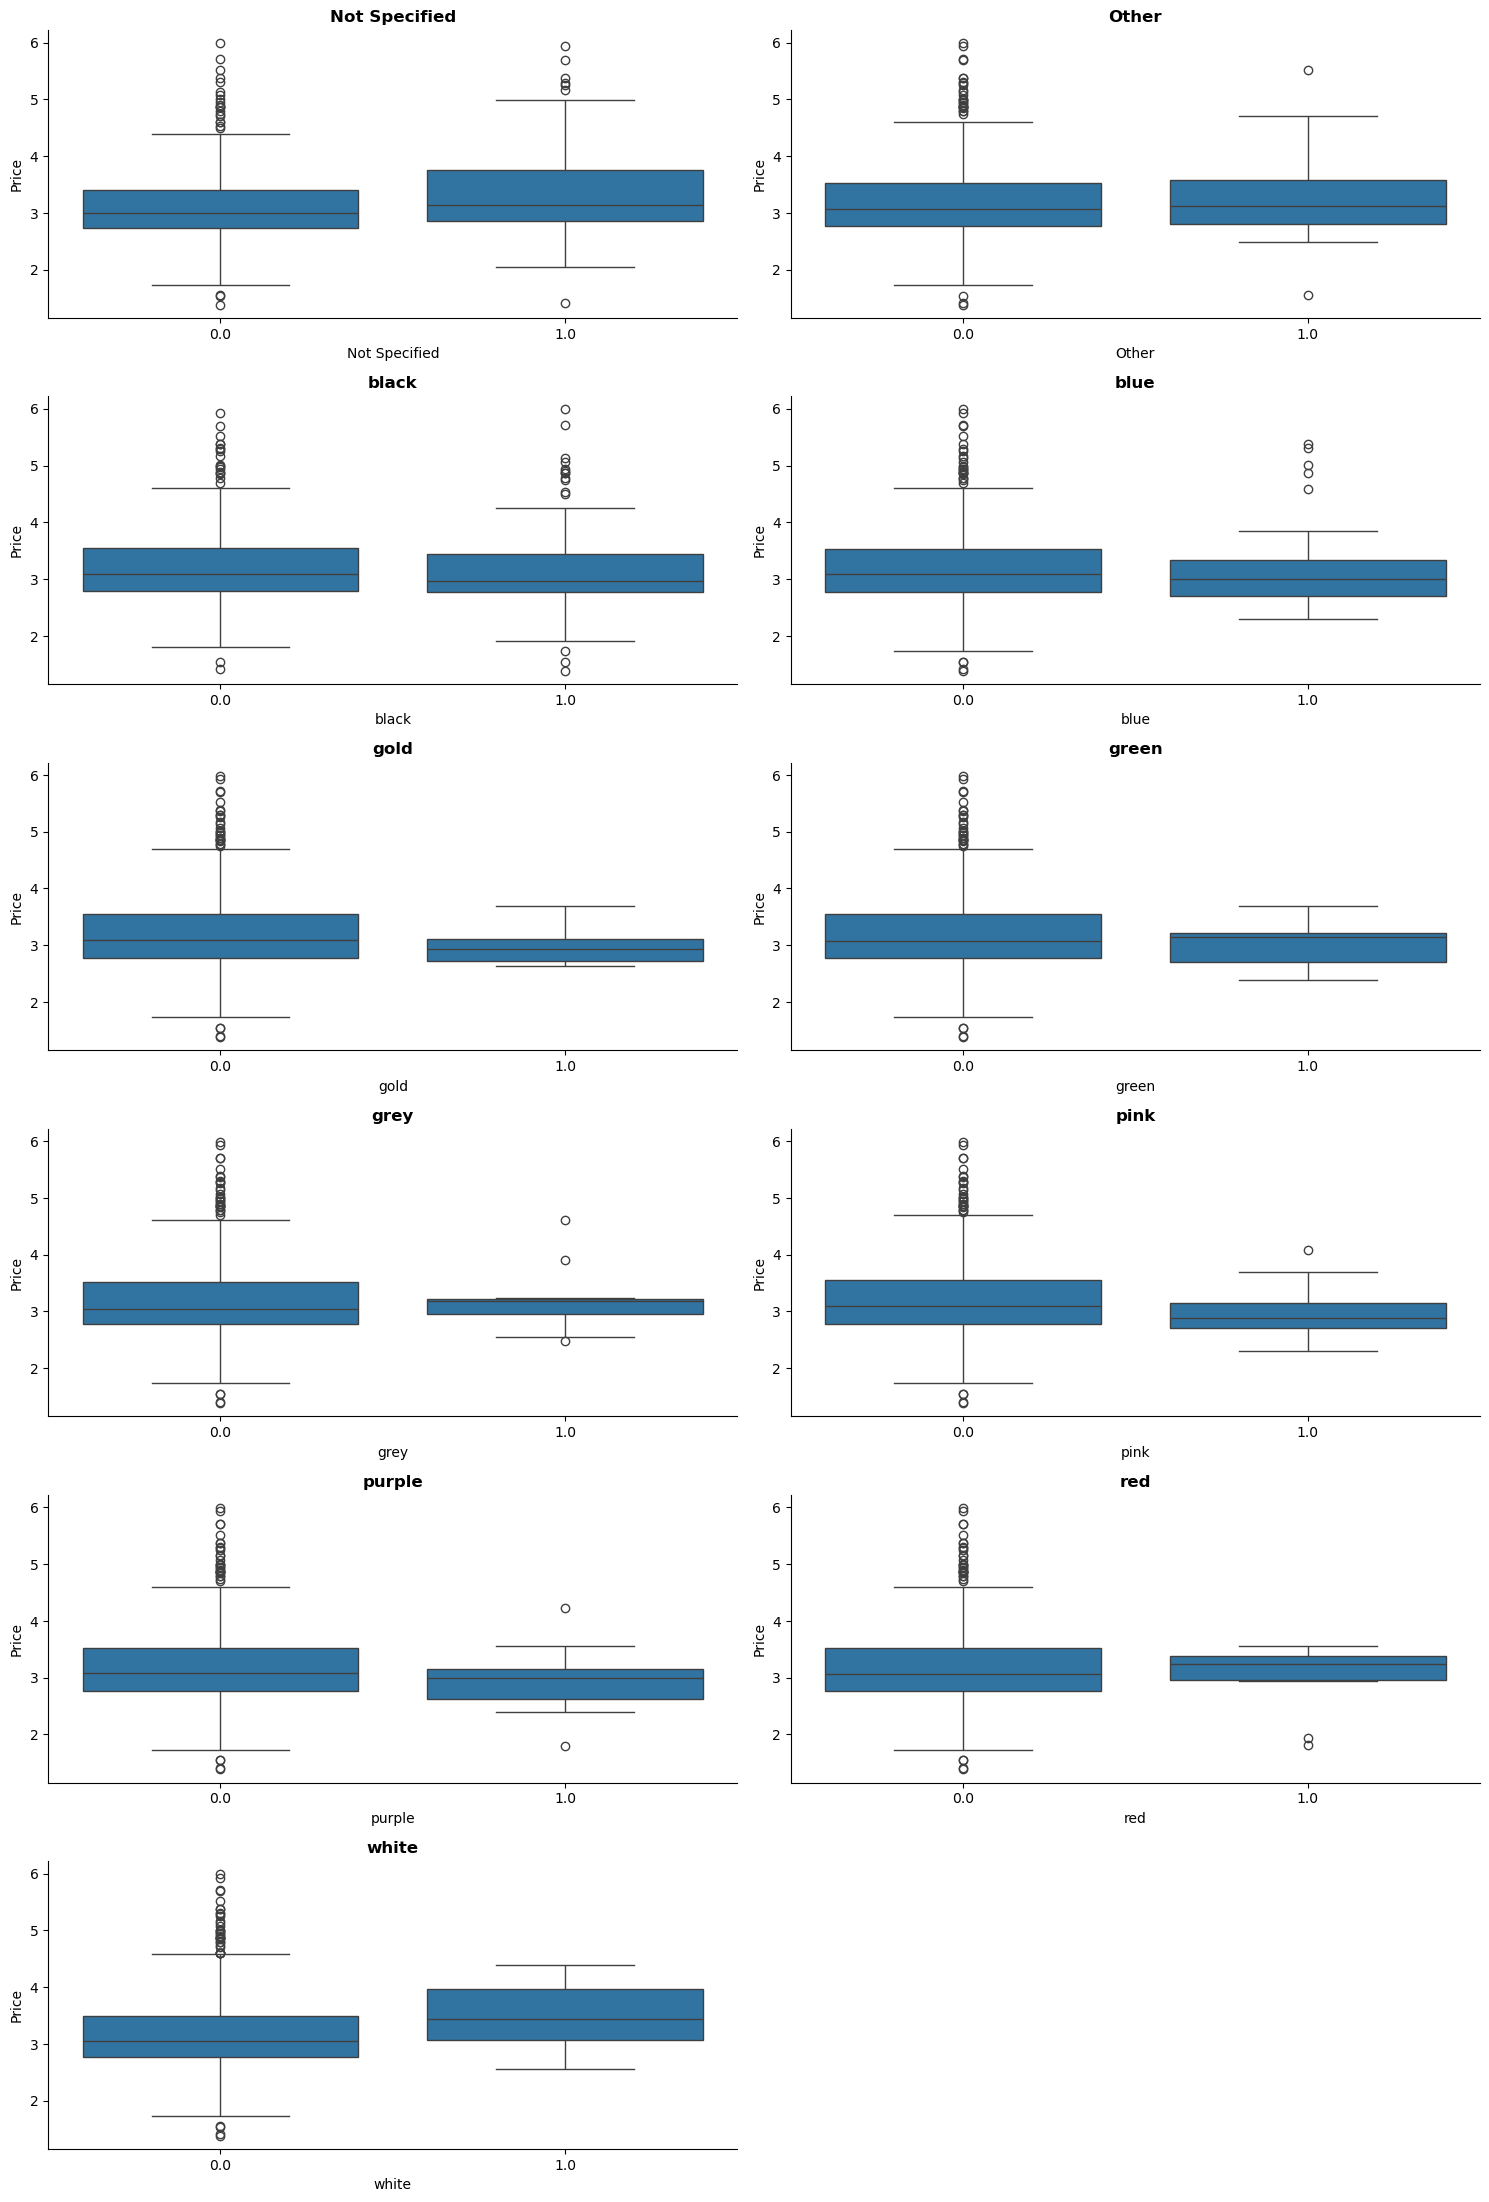

In [56]:
plt.figure(figsize=(15, 40)) 

for i, col in enumerate(colour_cols):
    plt.subplot(len(colour_cols), 2, i + 1)  
    sns.boxplot(x='Colour_' + col, y='price_trans', data=eda_df_final) 
    plt.title(f'{col}', fontweight='bold') 
    plt.xlabel(col)  
    plt.ylabel('Price')  
    ax = plt.gca()
    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout() 
plt.show()  

-----
**Plot Description:**

Minimal differences in price across the different colours, indicating that headphone colour has a minimal affect on headphone price. However, I have decided to include colour as a feature in the recommender system, as I think it is a significant aspect of user preference. 


## Correlation with Price/Rating
-----

In [73]:
columns = [ 'Rating', 'Is Prime', 'Wireless',
       'Noise Cancelling', 'Battery Life', 'Microphone', 'Over Ear', 'Gaming',
       'Foldable', 'price_trans', 'Colour_Not Specified', 'Colour_Other',
       'Colour_black', 'Colour_blue', 'Colour_gold', 'Colour_green',
       'Colour_grey', 'Colour_pink', 'Colour_purple', 'Colour_red',
       'Colour_white']

### Price

In [74]:
# Calculate correlation with price
corr = eda_df_final[columns].corr()
corr[['price_trans']].sort_values(by= 'price_trans', ascending=False)

,price_trans
price_trans,1.000000
Is Prime,0.409408
Noise Cancelling,0.283826
Rating,0.135069
Battery Life,0.127912
Colour_Not Specified,0.112846
Colour_white,0.063769
Colour_Other,0.013654
Colour_blue,0.000546
Colour_grey,-0.000930


----
**Comment:**

It is clear that Prime Eligibility and Foldable are the features that influence price the most.

Prime products show a significant increase in price of headphones, perhaps due faster shipping. 

Foldable headphones shows a negative correlation, suggesting that this feature may be associated with lower pricing. This could indicate that foldable design is  found in budget friendly headphones.

In addition, while noise-cancelling features also have a moderate positive correlation with price suggseting it is a more premium headphone feature.

Headphone colour, gaming capability and microphone presence all show minimal influence. This may reflect the class imbalance observed in the dataset, where certain features are underrepresented.

### Rating

In [69]:
# Calculate correlation with price
corr = eda_df_final[columns].corr()
corr[['Rating']].sort_values(by= 'Rating', ascending=False)

,Rating
Rating,1.000000
price_trans,0.135069
Battery Life,0.125861
Colour_green,0.097091
Noise Cancelling,0.076191
Foldable,0.068164
Over Ear,0.052763
Colour_gold,0.052632
Colour_Not Specified,0.050575
Microphone,0.041795


-----
**Comment:**

With ratings the correlation of features becomes weaker, this may be due to the over-representation we have in the data set of highly-reviewd headphones. As a result, it becomes challenging to determine which specific features are most strongly associated with higher or lower ratings.

## Conclusion
-----

Overall, the EDA has provided valuable insights into the features of the headphone dataset.

By assessing each feature individually, I identified class imbalances and skewness in the data. This is particularly important as I transition to modelling, as I have taken and will continue to take steps to ensure these issues do not affect the reliability of my model.

Through the multivariate analysis, I determined which features have the greatest influence on headphone prices.

These insights will be valuable as I move forward in building a recommendation system tailored to user preferences.